In [1]:
from magpi.prelude import *
from magpi.integrate import gauss, integrate, integrate_sphere
from magpi.calc import *
from magpi.opt import TR
import matplotlib.pyplot as plt
from magpi import r_fun
from magpi.domain import Sphere
from scipy.stats.qmc import Halton, Sobol
from magpi.surface_integral import charge_tensor, source_tensor, single_layer_potential, curl_single_layer_potential, integrate_surface, vector_potential_charge, integrate_surface_elements

%matplotlib widget

# Demagnetization of a hard magnetic sphere

In this notebook we compute the demagnetization process of a hard magnetic sphere using the vector potential and a PINN ansatz for $A_1$. The demagnetization is computed once for an external field parallel to the easy axis and once in a 45° angle to the easy axis.

First we define the material parameters:

In [2]:
mu0 = 4*pi*10**-7  # Tm/A
Js = 1.61  # T
Ms = Js / mu0  # A/m
Km = mu0 * Ms**2  # J/m3
R = 10.0  # nm
Ka = 4.3e6 / Km  # -
lex = 1.35  # nm
A = 7.3e-12 / Km * 1e18 / R ** 2 # 1/nm2
hext = -jnp.arange(0, 5, 0.005)  # -
dh = hext[0] - hext[1]

print("Decrease of external field for each step:", dh)

Decrease of external field for each step: 0.005


Next we use a parametrization for the surface of the sphere. See the notebook `sphere_self_energy.ipynb` for more information.

In [3]:
R = 1.0
def sphere_parametrization(u):
    phi = u[..., 0] * pi
    theta = u[..., 1] * 2 * pi
    x = R * sin(phi) * cos(theta)
    y = R * sin(phi) * sin(theta)
    z = R * cos(phi)
    return jnp.stack([x, y, z], axis=-1)

adf = r_fun.sphere(R)

_u, _v = jnp.linspace(0, 1, 7), jnp.linspace(0, 1, 7)

domain = Sphere(R, (0,0,0))
X = array(Halton(3, seed=1).random(2**12))
X = domain.transform(X)

X_val = array(Halton(3, seed=125).random(2**10))
X_val = domain.transform(X_val)

Then we need to define the PINN. it has the architecture [3, 12, 12, 3] with `gelu` activation functions and a linear activation function for the last layer. The model is then hard constrained via the approximate distance function `adf`.

Afterwards a PINN model for the magnetization is constructed. It has the same architecture (without ADF) but uses the Cayley transform on the last layer.

In [4]:
key = random.key(0)
m_init = lambda x: zeros_like(x).at[..., -1].set(1.0)

class VecPotential(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 12
        activation = nn.gelu
        x = x / 2
        y = activation(nn.Dense(nodes, kernel_init=nn.initializers.he_normal())(x))
        y = activation(nn.Dense(nodes, kernel_init=nn.initializers.he_normal())(y))
        y = nn.Dense(3, kernel_init=nn.initializers.he_normal())(y)
        return y
    
key, _k = random.split(key)
A1_model = VecPotential()
vec_pot_params_init = A1_model.init(_k, zeros((3,)))

def A1(x, params):
    return A1_model.apply(params, x)

class PINN(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 12
        activation = nn.gelu
        x = x / 2
        y = activation(nn.Dense(nodes, kernel_init=nn.initializers.he_normal())(x))
        y = activation(nn.Dense(nodes, kernel_init=nn.initializers.he_normal())(y))
        y = nn.Dense(3, kernel_init=nn.initializers.he_normal())(y)
        return y

key, _k = random.split(key)
mag_pinn_model = PINN()
pinn_params_init = mag_pinn_model.init(_k, zeros((3,)))

def to_skew_simmetric_matrix(x):
    S = zeros((3, 3))
    S = S.at[1, 0].set(x[2])
    S = S.at[2, 0].set(-x[1])
    S = S.at[2, 1].set(x[0])
    S = S - S.T
    return S

def cayley_rotation(p, x):
    assert p.shape[0] == 3, f"{p.shape}"
    Q = to_skew_simmetric_matrix(p)
    I = jnp.eye(3)
    return jnp.linalg.inv(I - Q) @ (I + Q) @ x


def mag(x, params):
    p = mag_pinn_model.apply(params, x)
    m = m_init(x)
    return cayley_rotation(p, m)

Next there are the definitions for the energy terms which rely heavily on AD.
Further, we define a function for Monte Carlo integration.

In [5]:
def mc_integrate(f, X, *args, **kwargs):
    return tree_map(lambda v: mean(v, axis=0) * ((4 / 3) * pi), vmap(lambda x: f(x, *args, *kwargs))(X))

def exchange_energy(x, params_m):
    dm = jacfwd(mag)(x, params_m)
    return A * jnp.sum(dm * dm)

def ani_energy(x, params_m):
    c = array([0., 0., 1.])
    return Ka * (1 - (mag(x, params_m) @ c) ** 2)

def ext_energy(x, params_m, hext, hext_axis):
    return - mag(x, params_m) @ (hext * hext_axis)

def solve_A2(mag, A1, params_mag=(), params_A1=()):
    charge_fn = vector_potential_charge(adf, mag, A1, normalized=True)
    c = charge_tensor(charge_fn, sphere_parametrization, _u, _v, params_mag=params_mag, params_A1=params_A1, order=2)
    
    def solve(z, grad_z):
        A2 = single_layer_potential(z, c)
        JA2 = single_layer_potential(grad_z, c)
        curl_A2 = curl_single_layer_potential(grad_z, c)
        return A2, JA2, curl_A2
    
    return solve

def mag_energy(x, params_m, A1, A2_JA2_curlA2):
    with jax.ensure_compile_time_eval():
        z, grad_z = source_tensor(x, sphere_parametrization, _u, _v, method=gauss(5), compute_jacfwd=True)
    
    m = lambda x: mag(x, params_m)
    _A1 = A1(x)
    lap_A1 = laplace(A1)(x)
    JA1 = jacfwd(A1)(x)
    curl_A1 = curl(A1)(x)
    A2, JA2, curl_A2 = A2_JA2_curlA2(z, grad_z)

    _curl_A = curl_A1 + curl_A2
    _curl_m = curl(m)(x)
    upper_bound = (norm(m(x)) ** 2 + jnp.sum(JA1 * JA1) - 2 * m(x) @ _curl_A -
                   _curl_m @ A2 + m(x) @ curl_A2 - lap_A1 @ A2)
    return 1 / 2 * (1 - (m(x) @ _curl_A)), 1 / 2 * upper_bound


def _integrand(x, params_m, params_old, hext, hext_axis, A2_JA2_curlA2):
    _, params_A1_old = params_old
    _A1 = lambda x: adf(x) * A1(x, params_A1_old)
    e_d, upper_bound = mag_energy(x, params_m, _A1, A2_JA2_curlA2)
    return dict(
        e_ex = exchange_energy(x, params_m),
        e_ani = ani_energy(x, params_m),
        e_ext = ext_energy(x, params_m, hext, hext_axis),
        e_d = e_d,
        upper_bound=upper_bound
    )

@jit
def loss_m(params_m, params_old, hext, hext_axis):
    params_m_old, params_A1_old = params_old
    A2_JA2_curlA2 = solve_A2(mag, A1, (params_m_old,), (params_A1_old,))
    energies = mc_integrate(_integrand, X, params_m, params_old, hext, hext_axis, A2_JA2_curlA2)
    l = (energies["e_ex"] + energies["e_ani"] + energies["e_ext"] + 2 * energies["e_d"]) / ((4 / 3) * pi)
    e_tot = (energies["e_ex"] + energies["e_ani"] + energies["e_ext"] + energies["e_d"])
    energies |= {"e_tot": e_tot}
    return l, energies


@jit
def loss_A1(params_A1, params_old):
    params_m, _  = params_old
    m = lambda x: mag(x, params_m)
    _A1 = lambda x: adf(x) * A1(x, params_A1)
    loss = lambda x: norm(laplace(_A1)(x) + curl(m)(x)) ** 2
    return mc_integrate(loss, X) / ((4 / 3) * pi)

## Alternating Optimization Scheme

Now we have two loss functions. One for the minization of $A_1$ (`loss_A1`) and one for the micromagnetic energy (`loss_m`).
We use an alternating optimization scheme to minimize these objectives. The `solve` function performs one minimization step for a given external field. Once both objectives are well minimized and the gradient of the parameters falls below a threshold, the external field is decreased by 0.005.

In [6]:
from jaxopt import OptStep
from magpi.tr import TR

@partial(jit, static_argnames=("solver1", "solver2",))
def run(solver1, solver2, params, state, hext, hext_axis):
    state1, state2 = state
    params1, params2 = params
    state1 = state1._replace(iter_num=0)
    step = OptStep(params1, state1)
    params1_new, state1 = solver1.run(step, params, hext, hext_axis)
    params_new = (params1_new, params2)
    state2 = state2._replace(iter_num=0)
    step = OptStep(params2, state2)
    params2_new, state2 = solver2.run(step, params_new)
    return (params1_new, params2_new), (state1, state2)


def update_hist(hist, params, state, iter_num, hext_axis):
    state1, state2 = state
    h = {
        "value_m": state1.value,
        "error_m": state1.error,
        "aux_m": state1.aux,
        "tr_radius_m": state1.tr_radius,
        "iter_num_m": state1.iter_num,
        "value_A1": state2.value,
        "error_A1": state2.error,
        "aux_A1": state2.aux,
        "tr_radius_A1": state2.tr_radius,
        "iter_num_A1": state2.iter_num,
        "iter_num": iter_num,
        "mean_mag": mean_mag(params[0], hext_axis)
    }
    hist.append(h)
    

@jit
def mean_mag(params, hext_axis):
    m = lambda x: mag(x, params)
    def m_proj(x):
        return m(x) @ hext_axis
    return mean(vmap(m_proj)(X_val))

tol_A1 = 1e-2
tol_m = 1e-3
def solve(params, state, hext, hext_axis, maxiter=50): 
    for i in range(maxiter):
        params, state = run(solver1, solver2, params, state, hext, hext_axis)
        error1 = tree_l2_norm(solver1.optimality_fun(params[0], params, hext, hext_axis))
        error2 = tree_l2_norm(solver2.optimality_fun(params[1], params))
        if error1 < tol_m and error2 < tol_A1:
            break
    return params, state, i

solver1 = TR(loss_m, has_aux=True, maxiter=10, tol=tol_m, damping_factor=1e-3, unroll=False)
solver2 = TR(loss_A1, has_aux=False, maxiter=20, tol=tol_A1, damping_factor=1e-3, unroll=False)

hext_axis = asarray([0, 0, 1])
params_init = (pinn_params_init, vec_pot_params_init)
hext_init = 1.0
state1 = solver1.init_state(params_init[0], params_init, hext_init, hext_axis)
state2 = solver2.init_state(params_init[1], params_init)
state_init = (state1, state2)

2024-12-13 16:15:14.932023: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.110 = f32[4096,468,1]{2,1,0} slice(f32[4096,468,3]{2,1,0} %constant.85), slice={[0:4096], [0:468], [2:3]}, metadata={op_name="jit(loss_m)/jit(main)/vmap(jit(cross))/slice[start_indices=(0, 0, 2) limit_indices=(4096, 468, 3) strides=None]" source_file="/home/sebastian/Workspace/jax_pinns/magpi/surface_integral.py" source_line=112}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-12-13 16:15:18.166667: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.234717622s
Constant f

Now this `solve` function is run for each step of the decreasing external field, where the external field is along the $[0, 0, 1.0]^T$ axis.

In [7]:
hext_axis = asarray([0, 0, 1.0])
_params = params_init
state = state_init
_params, state, iter_num = solve(_params, state, asarray(5.0), hext_axis)
hist1 = []
for h in hext:
    print(h)
    _params, state, iter_num = solve(_params, state, h, hext_axis)
    update_hist(hist1, _params, state, iter_num, hext_axis)

-0.0
-0.005
-0.01
-0.015
-0.02
-0.024999999
-0.03
-0.035
-0.04
-0.044999998
-0.049999997
-0.055
-0.06
-0.065
-0.07
-0.074999996
-0.08
-0.085
-0.089999996
-0.095
-0.099999994
-0.105
-0.11
-0.114999995
-0.12
-0.125
-0.13
-0.13499999
-0.14
-0.145
-0.14999999
-0.155
-0.16
-0.16499999
-0.17
-0.175
-0.17999999
-0.185
-0.19
-0.195
-0.19999999
-0.205
-0.21
-0.21499999
-0.22
-0.225
-0.22999999
-0.235
-0.24
-0.24499999
-0.25
-0.255
-0.26
-0.265
-0.26999998
-0.275
-0.28
-0.285
-0.29
-0.295
-0.29999998
-0.305
-0.31
-0.315
-0.32
-0.325
-0.32999998
-0.33499998
-0.34
-0.345
-0.35
-0.355
-0.35999998
-0.36499998
-0.37
-0.375
-0.38
-0.385
-0.39
-0.39499998
-0.39999998
-0.405
-0.41
-0.415
-0.42
-0.42499998
-0.42999998
-0.435
-0.44
-0.445
-0.45
-0.45499998
-0.45999998
-0.465
-0.47
-0.475
-0.48
-0.48499998
-0.48999998
-0.49499997
-0.5
-0.505
-0.51
-0.515
-0.52
-0.525
-0.53
-0.53499997
-0.53999996
-0.545
-0.55
-0.555
-0.56
-0.565
-0.57
-0.575
-0.58
-0.585
-0.59
-0.59499997
-0.59999996
-0.60499996
-0.61
-0.6

The same is done for the external field along the the axis $[0, \cos(\pi / 4), \sin(\pi / 4)]^T$

In [8]:
_params, state, iter_num = solve(_params, state, asarray(5.0), hext_axis)
hext_axis = asarray([0, cos(pi / 4), sin(pi / 4)])
_params = params_init
state = state_init
hist2 = []
for h in hext:
    print(h)
    _params, state, iter_num = solve(_params, state, h, hext_axis)
    update_hist(hist2, _params, state, iter_num, hext_axis)

-0.0
-0.005
-0.01
-0.015
-0.02
-0.024999999
-0.03
-0.035
-0.04
-0.044999998
-0.049999997
-0.055
-0.06
-0.065
-0.07
-0.074999996
-0.08
-0.085
-0.089999996
-0.095
-0.099999994
-0.105
-0.11
-0.114999995
-0.12
-0.125
-0.13
-0.13499999
-0.14
-0.145
-0.14999999
-0.155
-0.16
-0.16499999
-0.17
-0.175
-0.17999999
-0.185
-0.19
-0.195
-0.19999999
-0.205
-0.21
-0.21499999
-0.22
-0.225
-0.22999999
-0.235
-0.24
-0.24499999
-0.25
-0.255
-0.26
-0.265
-0.26999998
-0.275
-0.28
-0.285
-0.29
-0.295
-0.29999998
-0.305
-0.31
-0.315
-0.32
-0.325
-0.32999998
-0.33499998
-0.34
-0.345
-0.35
-0.355
-0.35999998
-0.36499998
-0.37
-0.375
-0.38
-0.385
-0.39
-0.39499998
-0.39999998
-0.405
-0.41
-0.415
-0.42
-0.42499998
-0.42999998
-0.435
-0.44
-0.445
-0.45
-0.45499998
-0.45999998
-0.465
-0.47
-0.475
-0.48
-0.48499998
-0.48999998
-0.49499997
-0.5
-0.505
-0.51
-0.515
-0.52
-0.525
-0.53
-0.53499997
-0.53999996
-0.545
-0.55
-0.555
-0.56
-0.565
-0.57
-0.575
-0.58
-0.585
-0.59
-0.59499997
-0.59999996
-0.60499996
-0.61
-0.6

In [9]:
import numpy as np
from scipy.optimize import bisect

_hs1 = asarray([h["mean_mag"] for h in hist1])[::-1]
def _g(x):
    return np.array(jnp.interp(x, hext[:len(_hs1)][::-1], _hs1))


hsw1 = bisect(_g, -5, -2)

_hs2 = asarray([h["mean_mag"] for h in hist2])[::-1]
def _g(x):
    return np.array(jnp.interp(x, hext[:len(_hs2)][::-1], _hs2))

hsw2 = bisect(_g, -5, -2)

mean_mags1 = asarray([h["mean_mag"] for h in hist1])
mean_mags2 = asarray([h["mean_mag"] for h in hist2])

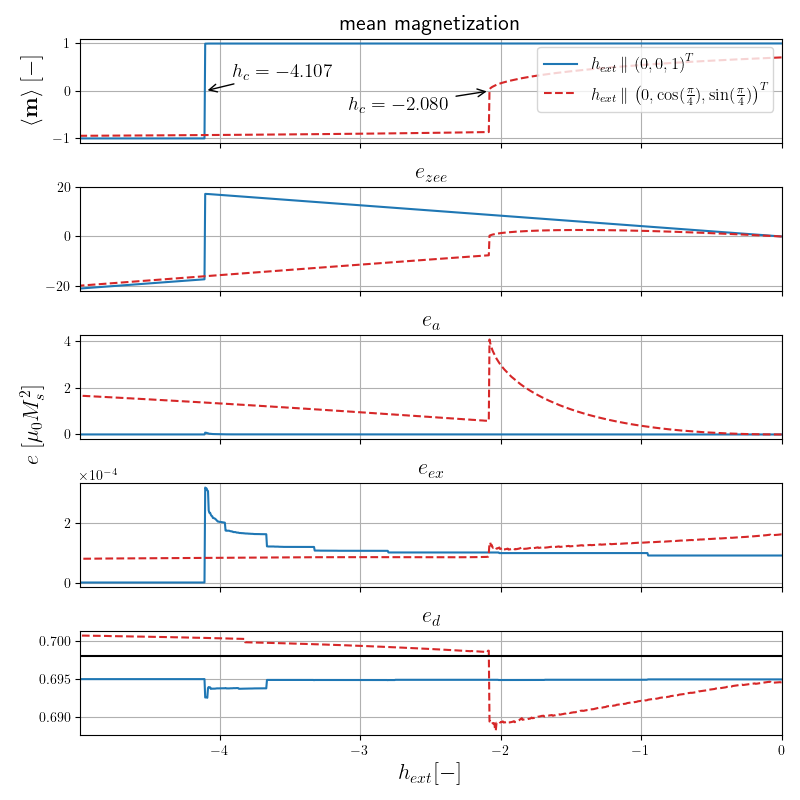

In [ ]:
with plt.rc_context(rc={'text.usetex': True, 'text.latex.preamble': r"\usepackage{amsmath}", "axes.labelsize": 16, "axes.titlesize": 16}):
    fig = plt.figure(figsize=(8, 8))
    ax1, ax2, ax3, ax4, ax5 = fig.subplots(5, 1, sharex=True)
    ax1.plot(hext[:len(hist1)], mean_mags1, c="tab:blue", label=r"$h_{ext}\,\|\,\left(0,0,1\right)^T$")
    ax1.plot(hext[:len(hist2)], mean_mags2, "--", c="tab:red", label=r"$h_{ext}\,\|\,\left(0, \cos(\frac{\pi}{4}), \sin(\frac{\pi}{4})\right)^T$")
    ax1.set_title("mean magnetization", fontsize=16)
    ax1.legend(fontsize=12, loc='upper right')
    ax1.grid()
    ax1.annotate(f"$h_c={hsw1:.3f}$", (hsw1, 0), (hsw1 + 0.2, +0.3), xycoords="data", fontsize=14, arrowprops={"arrowstyle": "->"})
    ax1.annotate(f"$h_c={hsw2:.3f}$", (hsw2, 0), (hsw2 - 1.0, -0.4), xycoords="data", fontsize=14, arrowprops={"arrowstyle": "->"})
    ax2.plot(hext[:len(hist1)], [h["aux_m"]["e_ext"] for h in hist1], c="tab:blue")
    ax2.plot(hext[:len(hist2)], [h["aux_m"]["e_ext"] for h in hist2], "--", c="tab:red")
    ax2.set_title("$e_{zee}$", fontsize=16)
    ax2.grid()
    ax2.set_ylim(-22, 20, )
    ax3.ticklabel_format(axis="y", style="sci", useOffset=True, scilimits=(0,0))
    ax3.plot(hext[:len(hist1)], [h["aux_m"]["e_ani"] for h in hist1], c="tab:blue")
    ax3.plot(hext[:len(hist2)], [h["aux_m"]["e_ani"] for h in hist2], "--", c="tab:red")
    ax3.set_title("$e_{a}$", fontsize=16)
    ax3.grid()
    ax4.ticklabel_format(axis="y", style="sci", useOffset=True, scilimits=(0,0))
    ax4.plot(hext[:len(hist1)], [h["aux_m"]["e_ex"] for h in hist1], c="tab:blue")
    ax4.plot(hext[:len(hist2)], [h["aux_m"]["e_ex"] for h in hist2], "--", c="tab:red")
    ax4.set_title("$e_{ex}$", fontsize=16)
    ax4.grid()
    ax5.plot(hext[:len(hist1)], [(h["aux_m"]["e_d"]) for h in hist1], label=r"$e_d^\mathbf{A}$", c="tab:blue")
    ax5.plot(hext[:len(hist2)], [(h["aux_m"]["e_d"]) for h in hist2], "--", label=r"$e_d^\mathbf{A}$", c="tab:red")
    ax5.hlines(4 * pi / 18, jnp.min(hext), jnp.max(hext), colors=["black"], label="$e_{d}$")
    ax5.set_title("$e_{d}$", fontsize=16)
    ax5.set_xlabel(r"$h_{ext} [-]$", fontsize=16)
    fig.text(0.04, 0.47, r"$e\;[\mu_0 M_s^2]$", ha='center', va='center', rotation='vertical', fontsize=16)
    fig.text(0.04, 0.89, r"$\langle \mathbf{m}\rangle \;[-]$", ha='center', va='center', rotation='vertical', fontsize=16)
    ax5.grid()
    ax5.set_xlim((min(hext),max(hext)))
    fig.tight_layout(rect=(0.03, 0, 1, 1))

    fig.savefig("demag_sphere_vec_pot.pdf")